# Data Cleaning

In [189]:
%reload_ext autoreload
%autoreload 2

# File imports
import signin_config
from book_functions import *

# Base imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy import stats
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# !pip install rake-nltk
from rake_nltk import Rake


# scraping imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


## Clean data 

- look for nan values, empty descriptions, clean types (str -> int), (organize pictures)
    ratings, number of ratings, pages (str -> int)


Merging with other dataframe -->

In [31]:
# df = pd.read_csv('goodread_data2_reb1.csv')
# df1 = df1 = pd.read_csv('cleaned_gr_data_quan2.csv')
# df_genres = pd.concat([df,df1], sort=True)
# df_parent = pd.concat([df,df1], sort=True)

In [32]:
# df_genres.drop(['Unnamed: 0','format'], axis=1, inplace=True) # drop format and random first column
# df_genres.pages = df_genres.pages.apply(lambda x: float(str(x).split(' ')[0]))
# df_genres.genre = df_genres.genre.apply(lambda x: x.replace('{','').replace('}',''))
# df_genres.genre = df_genres.genre.apply(lambda x: x.replace("'",''))
# df_genres['genre'] = df_genres['genre'].map(lambda x: x.lower().split(','))

In [135]:
df = pd.read_csv('goodread_img1.csv')
df.drop(['Unnamed: 0'], axis=1,inplace=True)#,'pages','format'], axis=1,inplace=True)

In [41]:
df.genre = df.genre.apply(lambda x: x.replace('{','').replace('}',''))
df.genre = df.genre.apply(lambda x: x.replace("'",''))
df['genre'] = df['genre'].map(lambda x: x.lower().split(','))

## NLP cleaning

Filtering, Stemming, Lemming and TF-IDF to produce an nlp-friendly dataset named 'nlp'

Functions to clean:

In [42]:
# new stopwords_list and regex pattern

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['book', 'author', 'novel', 'year', 'come', 'stories','story','thing','alex', 'stephanie', 
                   'bestseller']

In [43]:
nlp = pd.DataFrame(df.description)
nlp['describe_raw'] = nlp.description.apply(lambda info: nltk.regexp_tokenize(info, pattern));
nlp['raw_token'] = nlp.describe_raw.apply(lambda x: [word.lower() for word in x]);
nlp['token_list'] = nlp.raw_token.apply(lambda x : [word for word in x if word not in stopwords_list]);
nlp['freq_dist'] = nlp.describe_raw.apply(lambda x: FreqDist(x));
nlp['freq_dist_top'] = nlp.freq_dist.apply(lambda x: x.most_common(20));

# apply tfidf to vectorize
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
nlp['tfidf'] = tf.fit_transform(nlp['description'])

# TF-IDF Content-Based Recommendation System

## Based on Description
Cosine Similarities:


In [44]:
ds = df.copy(deep=False)

#getting stuck at 3998 for some reason
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] # not sure why this is here
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices]

    results[row['id']] = similar_items[1:]
    
print('done!')


KeyboardInterrupt: 

In [106]:
df.description.

,titles,authors,ratings,num_ratings,id,img,description,genre,key_words
0,"Anne of Avonlea (Anne of Green Gables, #2)",l.m.montgomery,4.22,126781,77390,https://i.gr-assets.com/images/S/compressed.ph...,At sixteen Anne is grown upalmost Her gray eye...,"[childrens, classics, historical, historicalfi...","[temper, arrived, avonlea, people, red, hair, ..."
1,Ethan Frome,edithwharton,3.39,100785,5246,https://i.gr-assets.com/images/S/compressed.ph...,He seemed a part of the mute melancholy landsc...,"[classics, academic, fiction, school, literature]","[seemed, hypochondriac, wife, zeena, possibili..."
2,The Arabian Nights,anonymous,4.05,70660,93101,https://i.gr-assets.com/images/S/compressed.ph...,The tales of told by Shahrazad over a thousand...,"[classics, shortstories, fantasy, fiction]","[bottles, one, nights, told, tale, intimate, r..."
3,Martin Eden,jacklondon,4.43,21445,929782,https://i.gr-assets.com/images/S/compressed.ph...,Alternate cover edition of ISBN The semiauto...,"[classics, american, literature, fiction]","[story, aggressively, dreams, eden, san, franc..."
4,"A Girl of the Limberlost (Limberlost, #2)",genestratton-porter,4.15,17932,17567,https://i.gr-assets.com/images/S/compressed.ph...,Set amid Indianas vast Limberlost Swamp this t...,"[childrens, classics, historical, historicalfi...","[northern, indiana, oil, production, gene, str..."


In [ ]:
recommend(item_id=11, num=5)

# Get Keywords

In [4]:
dff = pd.read_csv('goodreads_updated.csv')
dff.drop('Unnamed: 0', axis=1,inplace=True)
dff = dff.iloc[:7000]

In [5]:
# create author and genre column clean
dff['au_ge'] = dff.authors.apply(lambda x: x.lower().replace(' ','')) + ' ' + dff.genre.apply(lambda x: x.replace(' ','').replace(',',' ') if x!='set()' and type(x)!=float else ' ')
dff['au_ge'] = dff.au_ge.apply(lambda x: x.lower() if type(x) != float else x) 

In [169]:
string.punctuation + 'b'

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~b'

In [114]:
'rawr'.find('r')

0

In [137]:
for i in dff[dff.desc_clean.notnull() == True].desc_clean.tolist():
    if type(i)==bool:
        print(i)

In [149]:
len(list(dff.desc_clean.notnull))

TypeError: 'method' object is not iterable

In [154]:
des_kleen = dff[dff.desc_clean.notnull() == True]

In [170]:
# clean description for keyword search

dff['desc_clean'] = dff.description
for c in string.punctuation + '”' + '“':
    if c == '`' or c == "'":
        dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(c,"") if type(x)!=float else x)
    else:
        dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(c," ") if type(x)!=float else x)
for s in string.digits:
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace(s,"") if type(x)!=float else x)
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace('”','') if type(x)!=float else x)
    dff.desc_clean = dff.desc_clean.apply(lambda x: x.replace('“','') if type(x)!=float else x)

In [7]:
dff['key_words'] = ""
for idx, row in dff.iterrows():
    plot = row['desc_clean']
    if type(plot) == float:
        continue
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()
    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)
    # getting the dictionary with key words and their scores
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column
    keys = list(key_words_dict_scores.keys())
    keys = ' '.join(keys)
    dff.loc[idx, 'key_words'] = keys

In [8]:
dff['bag_of_words'] = dff.au_ge.apply(lambda x: x if type(x)!=float else '') + ' ' + dff.key_words.apply(lambda x: x if type(x)!=float else '')

In [9]:
dff.sample(5)

,titles,authors,ratings,num_ratings,id,img,description,pages,genre,format,isbn,au_ge,desc_clean,key_words,bag_of_words
5056,The Spanish Cape Mystery (Ellery Queen Detecti...,Jorge Amado,3.69,516,1951427,https://i.gr-assets.com/images/S/compressed.ph...,THE SPANISH CAPE MYSTERY is a study in jealous...,475,"Mystery, Fiction, Mystery, Detective",paperback,9780893405236,jorgeamado mystery fiction mystery detective,THE SPANISH CAPE MYSTERY is a study in jealous...,spanish cape mystery beautiful niece rosa rosa...,jorgeamado mystery fiction mystery detective s...
6924,"High Tide at Noon (Tide Trilogy, #1)",Gwethalyn Graham,4.30,215,995144,https://i.gr-assets.com/images/S/compressed.ph...,"The struggles, hardship, and joy of one woman'...",390,"Fiction, Historical, Historical Fiction",paperback,9780892722167,gwethalyngraham fiction historical historicalf...,The struggles hardship and joy of one womans l...,haunting story real bennetts island truthfulne...,gwethalyngraham fiction historical historicalf...
6161,The Matchlock Gun,William L. Shirer,3.70,7169,1351988,https://i.gr-assets.com/images/S/compressed.ph...,"A Newbery Medal Winner In 1756, New York Stat...",80,"Historical, Historical Fiction, Childrens, Fic...",paperback,9780698116801,williaml.shirer historical historicalfiction c...,A Newbery Medal Winner In New York State was...,indians little trudy original blackandwhite il...,williaml.shirer historical historicalfiction c...
4520,The Patch of Blue,Réginald Garrigou-Lagrange,4.03,217,500410,https://i.gr-assets.com/images/S/compressed.ph...,They lived in separate worlds until his world ...,302,"Romance, Christian Fiction, Fiction, Christian...",mass market paperback,9780842348096,réginaldgarrigou-lagrange romance christianfic...,They lived in separate worlds until his world ...,lived natalie th separate worlds never chris w...,réginaldgarrigou-lagrange romance christianfic...
6837,The Laughter of My Father,Margret Rey,4.10,242,3044254,https://i.gr-assets.com/images/S/compressed.ph...,NaN,152,Short Stories,paperback,NaN,margretrey shortstories,NaN,,margretrey shortstories


In [107]:
dff[dff.titles == 'Tales of the Don']

,titles,authors,ratings,num_ratings,id,img,description,pages,genre,format,isbn,au_ge,desc_clean,key_words,bag_of_words
3071,Tales of the Don,D.H. Lawrence,3.80,234,626403,NaN,NaN,NaN,"Cultural, Russia, Short Stories, Classics, Lit...",NaN,9780394447919,d.h.lawrence cultural russia shortstories clas...,NaN,,d.h.lawrence cultural russia shortstories clas...


In [54]:
dff.to_json(r'goodreads_updated.json', orient='index')

In [59]:
# import json
# with open('goodreads_updated.json') as f:
dat = pd.read_json('goodreads_updated.json', orient='index').reset_index(drop=True)

In [85]:
dat.iloc[0].titles

'Anne of Avonlea (Anne of Green Gables, #2)'

In [94]:
indices = pd.DataFrame(dat.titles, index=dat.index)

In [96]:
indices.iloc

,titles
0,"Anne of Avonlea (Anne of Green Gables, #2)"
1,Ethan Frome
2,Strait is the Gate
3,Burning Daylight
4,ابر شلوارپوش


In [104]:
indices[indices.titles == 'Ethan Frome'].index[0]

1

In [109]:
recommendations('Ethan Frome', dat, cosine_similarities)

,au_ge,authors,bag_of_words,desc_clean,description,format,genre,id,img,isbn,key_words,num_ratings,pages,ratings,titles
1090,edithwharton classics fiction literature acade...,Edith Wharton,edithwharton classics fiction literature acade...,He seemed a part of the mute melancholy landsc...,'He seemed a part of the mute melancholy lands...,paperback,"Classics, Fiction, Literature, Academic, School",5246,https://i.gr-assets.com/images/S/compressed.ph...,9780142437803.0,seemed obsessed comes incarnation maintain unp...,100785,189.000,3.39,Ethan Frome
1136,edithwharton classics fiction shortstories lit...,Edith Wharton,edithwharton classics fiction shortstories lit...,On a bleak New England farm a taciturn young m...,"On a bleak New England farm, a taciturn young ...",paperback,"Classics, Fiction, Short Stories, Literature",212525,https://i.gr-assets.com/images/S/compressed.ph...,9780553212556.0,unforgettable story bleak new england farm lan...,14888,336.000,3.66,Ethan Frome and Other Short Fiction
2075,ernesthemingway shortstories classics fiction ...,Ernest Hemingway,ernesthemingway shortstories classics fiction ...,None,None,None,"Short Stories, Classics, Fiction, Literature, ...",17332858,None,None,,215,2.000,3.16,A Very Short Story
2206,f.scottfitzgerald classics shortstories fictio...,F. Scott Fitzgerald,f.scottfitzgerald classics shortstories fictio...,Big twohearted river A way youll never be In...,Big two-hearted river -- A way you'll never be...,None,"Classics, Short Stories, Fiction, Literature, ...",815491,https://i.gr-assets.com/images/S/compressed.ph...,9781565113640,big twohearted river way youll never another c,858,90.000,3.88,Big Two-Hearted River
2041,franzkafka shortstories classics fiction europ...,Franz Kafka,franzkafka shortstories classics fiction europ...,None,None,None,"Short Stories, Classics, Fiction, European Lit...",9705409,https://i.gr-assets.com/images/S/compressed.ph...,None,,320,nan,3.47,"Josephine the Singer, or the Mouse Folk"
5236,louisberkhof shortstories fiction literature a...,Louis Berkhof,louisberkhof shortstories fiction literature a...,The Use of Force is a short story by the Ameri...,"The Use of Force"" is a short story by the Amer...",None,"Short Stories, Fiction, Literature, Academic, ...",13555711,https://i.gr-assets.com/images/S/compressed.ph...,None,see story sic narrated american author william...,395,nan,3.11,The Use of Force
2392,ernesthemingway shortstories classics fiction ...,Ernest Hemingway,ernesthemingway shortstories classics fiction ...,A Clean WellLighted Place is a short story by ...,"""A Clean, Well-Lighted Place"" is a short story...",hardcover,"Short Stories, Classics, Fiction, Literature, ...",553930,https://i.gr-assets.com/images/S/compressed.ph...,9780886823450,read best short stories ever written one clean...,4375,30.000,4.15,A Clean Well Lighted Place
4898,johnsteinbeck shortstories classics fiction li...,John Steinbeck,johnsteinbeck shortstories classics fiction li...,None,None,paperback,"Short Stories, Classics, Fiction, Literature, ...",2571737,https://i.gr-assets.com/images/S/compressed.ph...,9780895986955,,1391,33.000,3.72,The Chrysanthemums
383,edithwharton classics fiction romance,Edith Wharton,edithwharton classics fiction romance naive gi...,A naive girl from a humble background meets an...,A naive girl from a humble background meets an...,paperback,"Classics, Fiction, Romance",269528,https://i.gr-assets.com/images/S/compressed.ph...,9780486452388.0,naive girl novels candor ambitious city boy re...,9980,127.000,3.66,Summer
5566,geoffreytrease europeanliterature dutchliterat...,Geoffrey Trease,geoffreytrease europeanliterature dutchliterat...,In this humorous fantasy nineyearold Eric ente...,"In this humorous fantasy, nine-year-old Eric e...",hardcover,"European Literature, Dutch Literature, Fiction...",773338,https://i.gr-assets.com/images/S/compressed.ph...,9780395652312,humorous fantasy nineyearold eric enters hangs...,1779,196.000,3.55,Eric in the Land 

In [73]:
dict(dat.iloc[0])

{'au_ge': 'l.m.montgomery classics fiction youngadult historical historicalfiction childrens',
 'authors': 'L.M. Montgomery',
 'bag_of_words': 'l.m.montgomery classics fiction youngadult historical historicalfiction childrens strange behaviour frecklefaced orphan three rs arrived reputation getting anne begins red hair gray eyes shine like evening stars green gables learning meddles job adventures touch new schoolteacher people complicated life earned love scrapes funny bone enters womanhood sixteen character along temper peppery wonders someone elses romance finds two orphans years since teaching real test still heart grown upalmost handsome gilbert blythe avonlea',
 'desc_clean': 'At sixteen Anne is grown upalmost Her gray eyes shine like evening stars but her red hair is still as peppery as her temper In the years since she arrived at Green Gables as a frecklefaced orphan she has earned the love of the people of Avonlea and a reputation for getting into scrapes But when Anne begins 

In [77]:
data_df = pd.read_json('goodreads_updated.json', orient='index').reset_index(drop=True)

In [81]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data_df['bag_of_words'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)


In [44]:
daa = pd.DataFrame(data)

In [74]:
daa

,0,1,2,3,4,5,6,7,8,9,...,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999
titles,"Anne of Avonlea (Anne of Green Gables, #2)",Ethan Frome,The Arabian Nights,Martin Eden,"A Girl of the Limberlost (Limberlost, #2)",The Golden Bowl,The Machine Stops,"The Road to Oz (Oz, #5)",Peter Pan in Kensington Gardens / Peter and Wendy,The Tale of the Flopsy Bunnies,...,The Ghost and Mrs. Muir,Our Inner Conflicts: A Constructive Theory of ...,The Blood of Others,The Mystery of the Secret Room (The Five Find-...,"Berlin Diaries, 1940-1945",If He Hollers Let Him Go,Bosnian Chronicle,The Portable Poe,First Love and Other Novellas,حاجی‌آقا
authors,L.M. Montgomery,Edith Wharton,Anonymous,Jack London,Gene Stratton-Porter,Henry James,E.M. Forster,L. Frank Baum,J.M. Barrie,Beatrix Potter,...,Josephine Leslie,Karen Horney,Simone de Beauvoir,Enid Blyton,Marie Vassiltchikov,Chester Himes,Ivo Andrić,Edgar Allan Poe,Samuel Beckett,Sadegh Hedayat
ratings,4.22,3.39,4.05,4.43,4.15,3.79,4.07,3.76,4.06,4.19,...,4.16,4.21,3.98,4.05,4.08,3.97,4.25,4.31,3.81,3.83
num_ratings,126781,100785,70660,21445,17932,10488,7804,10101,5621,5664,...,1979,1388,1676,2717,1251,1728,1431,1922,1887,2023
id,77390,5246,93101,929782,17567,259020,4711854,179639,38673,19337,...,239437,130393,161557,17495,335238,52472,850223,794261,127286,659063
img,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...,https://i.gr-assets.com/images/S/compressed.ph...
description,"At sixteen, Anne is grown up...almost. Her gra...",'He seemed a part of the mute melancholy lands...,The tales of told by Shahrazad over a thousand...,Alternate cover edition of ISBN 9780140187724 ...,"Set amid Indiana's vast Limberlost Swamp, this...","'A thing to marvel at, a thing to be grateful ...",The Machine Stops is a science fiction short s...,"Meet Dorothy's new friends, the Shaggy Man, Bu...","In Peter Pan in Kensington Gardens, J.M. Barri...",When the cupboard is bare at the Flopsy Bunny'...,...,"Burdened by debt after her husband's death, Lu...","Unlike Freud, Horney does not regard neurosis ...","Jean Blomart, patriot leader against the Germa...","In the cold and foggy Christmas holidays, it d...",The secret diaries of a twenty-three-year-old ...,This story of a man living every day in fear o...,"Set in the town of Travnik, Bosnian Chronicle ...",This text includes all of Poe's best-known tal...,This new collection brings together First Love...,چاپّ اوّلِ این‌کتاب به‌سالِ 1324 توسّطِ نویسند...
pages,304,189,1049,480,222,591,48,261,288,58,...,174,256,240,217,324,203,437,666,106,110
genre,"Classics, Fiction, Young Adult, Historical, Hi...","Classics, Fiction, Literature, Academic, School","Classics, Fiction, Fantasy, Short Stories, Lit...","Classics, Fiction, Literature, American","Classics, Fiction, Young Adult, Historical, Hi...","Classics, Fiction, Literature, Literature, Ame...","Science Fiction, Short Stories, Fiction, Class...","Fantasy, Classics, Childrens, Fiction","Classics, Fantasy, Fiction, Childrens","Childrens, Childrens, Picture Books, Classics,...",...,"Fiction, Classics, Romance, Fantasy, Historica...","Psychology,

In [28]:
dat = pd.DataFrame(data)
dat.head()

,0,1,2,3,4,5,6,7,8,9,...,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999
titles,"Anne of Avonlea (Anne of Green Gables, #2)",Ethan Frome,The Arabian Nights,Martin Eden,"A Girl of the Limberlost (Limberlost, #2)",The Golden Bowl,The Machine Stops,"The Road to Oz (Oz, #5)",Peter Pan in Kensington Gardens / Peter and Wendy,The Tale of the Flopsy Bunnies,...,The Ghost and Mrs. Muir,Our Inner Conflicts: A Constructive Theory of ...,The Blood of Others,The Mystery of the Secret Room (The Five Find-...,"Berlin Diaries, 1940-1945",If He Hollers Let Him Go,Bosnian Chronicle,The Portable Poe,First Love and Other Novellas,حاجی‌آقا
authors,L.M. Montgomery,Edith Wharton,Anonymous,Jack London,Gene Stratton-Porter,Henry James,E.M. Forster,L. Frank Baum,J.M. Barrie,Beatrix Potter,...,Josephine Leslie,Karen Horney,Simone de Beauvoir,Enid Blyton,Marie Vassiltchikov,Chester Himes,Ivo Andrić,Edgar Allan Poe,Samuel Beckett,Sadegh Hedayat
ratings,4.22,3.39,4.05,4.43,4.15,3.79,4.07,3.76,4.06,4.19,...,4.16,4.21,3.98,4.05,4.08,3.97,4.25,4.31,3.81,3.83
num_ratings,126781,100785,70660,21445,17932,10488,7804,10101,5621,5664,...,1979,1388,1676,2717,1251,1728,1431,1922,1887,2023
id,77390,5246,93101,929782,17567,259020,4711854,179639,38673,19337,...,239437,130393,161557,17495,335238,52472,850223,794261,127286,659063


# Bag of Words

In [524]:
dff['bag_of_words'] = dff.au_ge + ' ' + dff.key_words

TypeError: can only join an iterable

Stop here - clean below before final push

# NLP Topic Modeling

## Preprocessing data

In [130]:
processed_docs = df['description'].map(preprocess)

In [131]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [132]:
dictionary.filter_extremes(no_below=20, no_above=0.66, keep_n=10000)

## Bag of Words on dataset

In [133]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [134]:
bow_doc_2001 = bow_corpus[2001]

In [135]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [140]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=4, workers=2)

In [141]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"love" + 0.012*"life" + 0.010*"famili" + 0.010*"world" + 0.009*"girl" + 0.009*"know" + 0.008*"night" + 0.008*"secret" + 0.007*"power" + 0.007*"live"
Topic: 1 
Words: 0.011*"time" + 0.010*"life" + 0.009*"girl" + 0.009*"want" + 0.007*"world" + 0.007*"like" + 0.007*"know" + 0.007*"think" + 0.007*"secret" + 0.007*"peopl"
Topic: 2 
Words: 0.013*"famili" + 0.013*"life" + 0.011*"live" + 0.010*"love" + 0.009*"world" + 0.007*"time" + 0.006*"year" + 0.006*"work" + 0.005*"write" + 0.005*"woman"
Topic: 3 
Words: 0.015*"world" + 0.013*"love" + 0.010*"vampir" + 0.009*"live" + 0.009*"power" + 0.008*"magic" + 0.008*"secret" + 0.008*"life" + 0.007*"human" + 0.006*"danger"
Topic: 4 
Words: 0.013*"know" + 0.011*"dead" + 0.011*"world" + 0.008*"want" + 0.008*"like" + 0.007*"time" + 0.007*"life" + 0.006*"bestsel" + 0.006*"power" + 0.006*"rise"
Topic: 5 
Words: 0.013*"world" + 0.007*"live" + 0.006*"life" + 0.006*"famili" + 0.006*"lose" + 0.005*"take" + 0.005*"dead" + 0.005*"bestsel" + 

In [142]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"love" + 0.003*"life" + 0.003*"time" + 0.003*"kate" + 0.003*"live" + 0.002*"famili" + 0.002*"know" + 0.002*"want" + 0.002*"world" + 0.002*"woman"
Topic: 1 Word: 0.003*"girl" + 0.003*"love" + 0.003*"world" + 0.003*"famili" + 0.003*"secret" + 0.003*"time" + 0.002*"know" + 0.002*"life" + 0.002*"father" + 0.002*"live"
Topic: 2 Word: 0.003*"world" + 0.003*"life" + 0.002*"live" + 0.002*"love" + 0.002*"know" + 0.002*"famili" + 0.002*"time" + 0.002*"like" + 0.002*"think" + 0.002*"power"
Topic: 3 Word: 0.003*"love" + 0.003*"life" + 0.003*"want" + 0.003*"know" + 0.003*"friend" + 0.003*"world" + 0.002*"famili" + 0.002*"secret" + 0.002*"time" + 0.002*"live"
Topic: 4 Word: 0.003*"life" + 0.003*"love" + 0.003*"know" + 0.003*"famili" + 0.003*"friend" + 0.002*"time" + 0.002*"leav" + 0.002*"girl" + 0.002*"come" + 0.002*"world"
Topic: 5 Word: 0.004*"love" + 0.003*"vampir" + 0.003*"life" + 0.003*"famili" + 0.002*"world" + 0.002*"live" + 0.002*"know" + 0.002*"power" + 0.002*"peopl" + 

In [148]:
processed_docs[7090447]

['mother',
 'death',
 'year',
 'carter',
 'kane',
 'live',
 'suitcas',
 'travel',
 'globe',
 'father',
 'brilliant',
 'egyptologist',
 'julius',
 'kane',
 'carter',
 'homeschool',
 'younger',
 'sister',
 'sadi',
 'live',
 'grandpar',
 'london',
 'sadi',
 'carter',
 'want',
 'school',
 'friend',
 'chanc',
 'normal',
 'life',
 'carter',
 'sadi',
 'long',
 'time',
 'father',
 'year',
 'live',
 'apart',
 'sibl',
 'common',
 'christma',
 'sadi',
 'carter',
 'reunit',
 'father',
 'bring',
 'british',
 'museum',
 'promis',
 'go',
 'thing',
 'right',
 'accord',
 'plan',
 'carter',
 'sadi',
 'watch',
 'julius',
 'summon',
 'mysteri',
 'figur',
 'quick',
 'banish',
 'father',
 'caus',
 'fieri',
 'explos',
 'soon',
 'carter',
 'sadi',
 'discov',
 'god',
 'ancient',
 'egypt',
 'wake',
 'worst',
 'frighten',
 'scheme',
 'save',
 'father',
 'embark',
 'danger',
 'journey',
 'quest',
 'bring',
 'closer',
 'truth',
 'famili',
 'link',
 'hous',
 'life',
 'secret',
 'order',
 'exist',
 'time',
 'pharaoh

In [ ]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

then on unseen document

## Topic Clustering

### Pearson Correlation

from https://github.com/nikitaa30/Content-based-Recommender-System/blob/master/recommender_system.py

## EDA of continuous data

In [248]:
df_genres.pages.describe()

count   4183.000
mean     380.532
std      191.497
min        2.000
25%      292.000
50%      356.000
75%      435.000
max     5216.000
Name: pages, dtype: float64

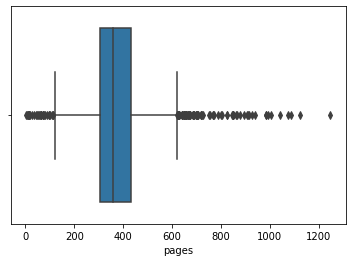

In [77]:
sns.boxplot(df_genres.pages);

In [102]:
df_genres.num_ratings.describe()

count      1990.000
mean      85340.892
std      160750.248
min         293.000
25%       29074.250
50%       47486.000
75%       83685.750
max     3140387.000
Name: num_ratings, dtype: float64

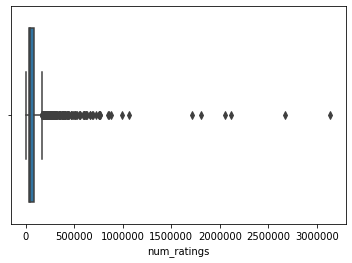

In [98]:
sns.boxplot(df_genres.num_ratings);

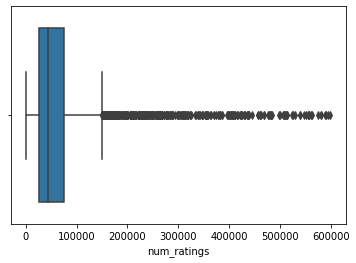

In [175]:
sns.boxplot(less.num_ratings)

In [166]:
len(df)/3

1394.3333333333333

In [168]:
len(df[(df.num_ratings > 80000)]) #& (df.num_ratings > 27000)])

1055

In [150]:
df.num_ratings.describe()

count      4183.000
mean      92458.276
std      222317.413
min         293.000
25%       27043.500
50%       44106.000
75%       80462.000
max     5851687.000
Name: num_ratings, dtype: float64

In [511]:
df = pd.read_csv('keywords.csv')

Function to be

In [112]:
for item in dff.desc_clean:
    print (item)

At sixteen Anne is grown upalmost Her gray eyes shine like evening stars but her red hair is still as peppery as her temper In the years since she arrived at Green Gables as a frecklefaced orphan she has earned the love of the people of Avonlea and a reputation for getting into scrapes But when Anne begins her job as the new schoolteacher the real test of her character begins Along with teaching the three Rs she is learning how complicated life can be when she meddles in someone elses romance finds two new orphans at Green Gables and wonders about the strange behaviour of the very handsome Gilbert Blythe As Anne enters womanhood her adventures touch the heart and the funny bone
He seemed a part of the mute melancholy landscape an incarnation of its frozen woe with all that was warm and sentient in him fast bound below the surface  Ethan Frome works his unproductive farm and struggles to maintain a bearable existence with his difficult suspicious and hypochondriac wife Zeena But when Ze

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [200]:
def process_and_almost_bag(authors, genre, desc_clean):
    ''' Returns a cleaned column of author and genre combined, as well as the keywords in description. '''
    # create author and genre column clean
    au_ge = authors.apply(lambda x: x.lower().replace(' ','').replace('.','')) + ' ' + genre.apply(lambda x: x.replace(' ','').replace(',',' ') if x!='set()' and type(x)!=float else ' ')
    au_ge = au_ge.apply(lambda x: x.lower() if type(x) != float else x) 

    
    # clean description for keyword search
    for c in string.punctuation + '”' + '“':
        if c == '`' or c == "'":
            desc_clean = dff.desc_clean.apply(lambda x: x.replace(c,"") if type(x)!=float else x)
        else:
            desc_clean = dff.desc_clean.apply(lambda x: x.replace(c," ") if type(x)!=float else x)
            
    for s in string.digits:
        desc_clean = desc_clean.apply(lambda x: x.replace(s,"") if type(x)!=float else x)

    # get keywords using Rake
    keywords = []
    for plot in desc_clean:
        if type(plot) == float:
            keywords.append(np.nan)
            continue
        keys = ' '.join(make_keywords(plot))
        keywords.append(keys)
        
    return au_ge, pd.Series(keywords)


In [201]:
def make_bow(au_ge, keywords):
    '''create a bag of words that combines the clean author/genre and keywords from process_and_almost_bag '''
    return au_ge.apply(lambda x: x if type(x)!=float else '') + ' ' + keywords.apply(lambda x: x if type(x)!=float else '')

In [203]:
aug, kee = process_and_almost_bag(dff.authors, dff.genre, dff.desc_clean)
boow = make_bow(aug, kee)

In [204]:
boow

0       lmmontgomery classics fiction youngadult histo...
1       edithwharton classics fiction literature acade...
2       anonymous classics fiction fantasy shortstorie...
3       jacklondon classics fiction literature america...
4       genestratton-porter classics fiction youngadul...
                              ...                        
6995    chesterhimes fiction cultural africanamerican ...
6996    ivoandrić fiction historical historicalfiction...
6997    edgarallanpoe classics poetry horror fiction s...
6998    samuelbeckett shortstories fiction europeanlit...
6999    sadeghhedayat literature fiction novels چاپ ّ ...
Length: 7000, dtype: object